
## Metaflow Scaling and Production

### Metaflow on GCP

The true power of Metaflow comes in when we decide to use a different *compute layer*, that is, instead of using our laptop, we send the computations to AWS, GCP, Azure, or K8s. To set up Metaflow on any one of these cloud platforms, there are instructions [here](https://outerbounds.com/engineering/welcome/). For this demo, I will be using GCP. 

To use GCP, here is an overview of the steps, many of which you should already have completed from previous labs. 

Install Tools:  
- Install Terraform (infrastructure-as-code tool) [here](https://developer.hashicorp.com/terraform/tutorials/aws-get-started/install-cli)  
- Install the GCP CLI [here](https://cloud.google.com/sdk/docs/install-sdk)  
- Install kubectl [here](https://kubernetes.io/docs/tasks/tools/#kubectl)  
- Install kubernetes python library in your environment `pip install kubernetes`

Clone Repository with Terraform Templates:  
- Clone this repository into your project directory: [https://github.com/outerbounds/metaflow-tools](https://github.com/outerbounds/metaflow-tools)  
`git clone git@github.com:outerbounds/metaflow-tools.git` or `git clone https://github.com/outerbounds/metaflow-tools.git`. 

Feel free to remove the aws and azure folders if you want to clean up.

Create a Project in GCP and Enable Services: 

To see which services are already enabled you can use 

`gcloud services list`

- Enable these APIs:  
    - Cloud Resource Manager: `gcloud services enable cloudresourcemanager.googleapis.com`  
    - Compute Engine API:  `gcloud services enable compute.googleapis.com`  
    - Service Networking: `gcloud services enable servicenetworking.googleapis.com`  
    - Cloud SQL Admin API: `gcloud services enable sqladmin.googleapis.com`    
    - Kubernetes Engine API: `gcloud services enable container.googleapis.com`  

Provision and Deploy Infrastructure in GCP:  
- Login to GCP `gcloud auth application-default login`    
- Initialize Terraform: From `metaflow-tools/gcp/terraform` run `terraform init`    
- Set some Terraform variables: Create a file called `metaflow.tfvars` and add the following to it:

```
org_prefix = "<ORG_PREFIX>"
project = "<GCP_PROJECT_ID>"
enable_argo=true
```

ORG_PREFIX should just be a short unique name, this will be the name of the GCS bucket. GCP_PROJECT_ID is the project ID you created in GCP.

- Provision the GCP infrastructure using Terraform. From `metaflow-tools/gcp/terraform` run `terraform apply -target="module.infra" -var-file=metaflow.tfvars`    
- Deploy services using Terraform. From `metaflow-tools/gcp/terraform` run `terraform apply -target="module.services" -var-file=metaflow.tfvars` 

In the above we use the `-target` option to target which parts of the configuration to *apply*. Supposedly it is easier to troubleshoot errors this way, and you can be sure to apply certain parts of the infrastructure first that might be needed by other parts of the infrastructure. 

Configure Metaflow to Work with GCP and Kubernetes:  
- Verify we can access our infrastructure:

```
gcloud auth application-default login
gcloud container clusters get-credentials gke-metaflow-default --region=us-west2-a
```

You may need to install the GKE gcloud auth plugin:

`gcloud components install gke-gcloud-auth-plugin`

- Configure Metaflow. Create the file `~/.metaflowconfig/config.json` and add the following to it. Replace the `<org-prefix>` with the one you chose above.  

```
{
    "METAFLOW_DATASTORE_SYSROOT_GS": "gs://storage-<org-prefix>-metaflow-default/tf-full-stack-sysroot",
    "METAFLOW_DEFAULT_DATASTORE": "gs",
    "METAFLOW_DEFAULT_METADATA": "service",
    "METAFLOW_KUBERNETES_NAMESPACE": "argo",
    "METAFLOW_KUBERNETES_SERVICE_ACCOUNT": "argo",
    "METAFLOW_SERVICE_INTERNAL_URL": "http://metadata-service.default:8080/",
    "METAFLOW_SERVICE_URL": "http://127.0.0.1:8080/"
}
```
- Setup the port-forwards by running the following script in a new terminal. This will run the port-forwards automatically and will avoid timeouts: `python metaflow-tools/scripts/forward_metaflow_ports.py --include-argo` (keep this terminal open and continue working in a new terminal)
- Install GCP Python SDK in your project environment: `pip install google-cloud-storage google-auth` 


One thing to be careful of, if you run all of this on a project, and then you want to run it on a new project, you may need to run some commands. You can check which project you are in by running:

`gcloud config get-value project`

You can see the list of available projects:

`gcloud projects list`

You can switch to a new project: 

`gcloud config set project <project_id>`  

You may also need to set the quota/billing project:

`gcloud auth application-default set-quota-project <project_id>`  

And you can always check which project is the default quota/billing project by looking in this file:  

`~/.config/gcloud/application_default_credentials.json`  


There are also configuration files in the `~/.config/gcloud/configurations/` folder. These are created when you run `gcloud init`. You always check these to make sure the correct project is listed there, and if not, you can edit the file. You can use `gcloud config list` to see which configuration is active, and activate a configuration using `gcloud config configurations activate <config-name>`.



### Dependencies with @conda pg 143 192

If we want to truly make our flows reproducible then we should define the environment that our flows will run in. We can do this using the `@conda` or `@conda_base` decorators. With these decorators we can be very specific as to which version of python, and which versions of python libraries we are using in each step. We can even choose different versions of the same library to run in different steps.

Metaflow using the conda package manager by default, and so before using these decorators you may have to set an environment variable called CONDA_CHANNELS to conda-forge in your `.bash_profile` or `.zprofile` or `.profile` or wherever your environment variables are set. I'm using zsh, so I set my environment variable in my `.zprofile` file.

Add this line to the profile: `export CONDA_CHANNELS=conda-forge`  
Then run `source ~/.zprofile`.

Now, let's modify our `classifier_train.py` file to do more than just train 2 different models. We'll make the DAG dynamic by adding a `foreach` in the first step, and then we'll add a `train_lasso` step where we train a Lasso model using a set of values for `alpha`. If we create five values of `alpha`, then the flow will spin off five nodes in the DAG. Let's set all of our dependencies using `@conda_base`, but note you can also do this separately for each step in the flow as well.

```
from metaflow import FlowSpec, step, conda_base

@conda_base(libraries={'numpy':'1.23.5', 'scikit-learn':'1.2.2'}, python='3.9.16')
class ClassifierTrainFlow(FlowSpec):

    @step
    def start(self):
        from sklearn import datasets
        from sklearn.model_selection import train_test_split
        import numpy as np

        X, y = datasets.load_wine(return_X_y=True)
        self.train_data, self.test_data, self.train_labels, self.test_labels = train_test_split(X,y, test_size=0.2, random_state=0)
        print("Data loaded successfully")
        self.lambdas = np.arange(0.001, 1, 0.2)
        self.next(self.train_lasso, foreach='lambdas')

    @step
    def train_lasso(self):
        from sklearn.linear_model import Lasso

        self.model = Lasso(alpha=self.input)
        self.model.fit(self.train_data, self.train_labels)
        self.next(self.choose_model)

    @step
    def choose_model(self, inputs):
        def score(inp):
            return inp.model, inp.model.score(inp.test_data, inp.test_labels)

        self.results = sorted(map(score, inputs), key=lambda x: -x[1])
        self.model = self.results[0][0]
        self.next(self.end)

    @step
    def end(self):
        print('Scores:')
        print('\n'.join('%s %f' % res for res in self.results))
        print('Model:', self.model)


if __name__=='__main__':
    ClassifierTrainFlow()
```

Once the above script is saved as `classifier_train_more.py`, you can run it using `python classifier_train_more.py --environment=conda run`. This will take a little bit of time while the environment is being set up. The next time you run it, it will run much faster since all of the dependencies have already been installed.

In the next step, we'll run the same flow in kubernetes.


### @kubernetes and @resources

You can test if things are working by running: `python classifier_train_more.py --environment=conda run --with kubernetes`. It may take some time to create all of the containers and run everything, but it *should* be successful. You may want to modify the resources using the `@resources` decorator to see if it has any effect on the performance, but for our dataset here, which is small, it will likely not make much difference.

Don't be surprised that the flow takes a lot longer to run in kubernetes. It runs quickly on your laptop because the data is small and the computation is easy. In kubernetes there is a lot of overhead involved in creating pods and containers and such. But, let's run a few more models anyways, just to continue to test our flows running in kubernetes. Modify the `classifier_train_more.py` script by changing the following line:

`self.lambdas = np.arange(0.001, 1, 0.2)`

to 

`self.lambdas = np.arange(0.001, 1, 0.01)`

This code will attempt to train more models. It will still run fast on your laptop, and slow in kubernetes, but that's ok. Kubernetes is where you want things to run in production so that it *can* scale and deal with failures.

### @timeout, @retry and @catch 

Note that anytime you are running flows in an orchestrator, you should use the `@retry` decorator to avoid any transient infrastructure issues so that the step will terminate and run again if nothing is happening. You can also add a `@timeout` decorator to any steps that you feel should run in under a certain amount of time. Lastly, you can use the `@catch` decorator to tell Metaflow what to do when an exception is caught.

You can also include the `retry` when you run the flow, like this: `python classifier_train_more.py --environment=conda run --with retry`. 



### Scheduling with @schedule

Metaflow is not a scheduler. Unfortunately, if you want to run a flow in production you will need to take your flow and run it in a separate scheduler, such as Airflow or Argo Workflows. The way we set up our infrastructure on GCP above, we will use Argo Workflows to schedule our flows to run.

First, let's add `@schedule(hourly=True)` to the top of our flow, and save the script as `classifier_train_prod.py`.

Then we can create a new Argo Workflow by running 

`python classifier_train_prod.py --environment=conda --with retry argo-workflows create`

After you run this command you can go into the Argo server (remember those port-forwards we did up above). In the Argo UI click `Submit New Workflow`, then find the flow you just created, and hit `Submit`. You should then see the flow running. 

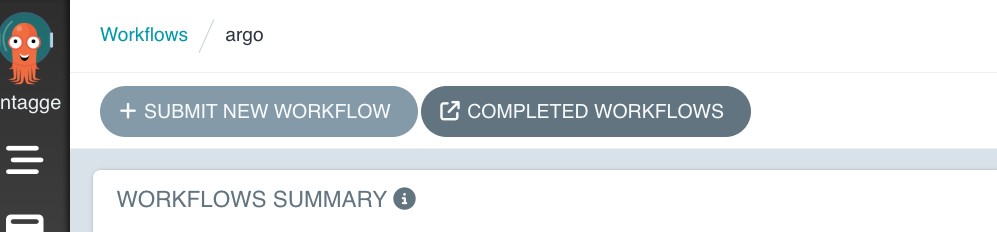

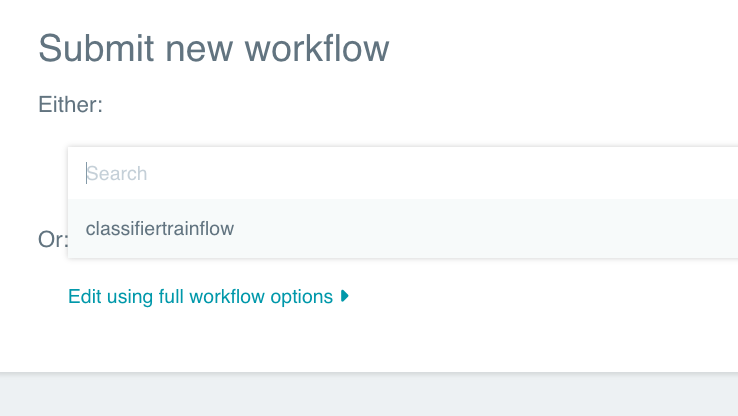

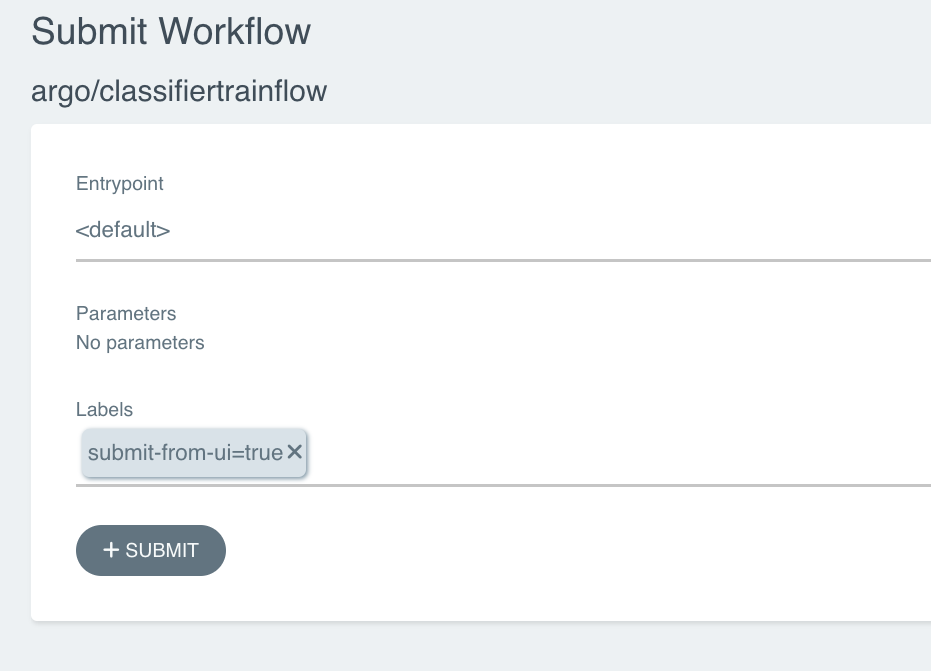

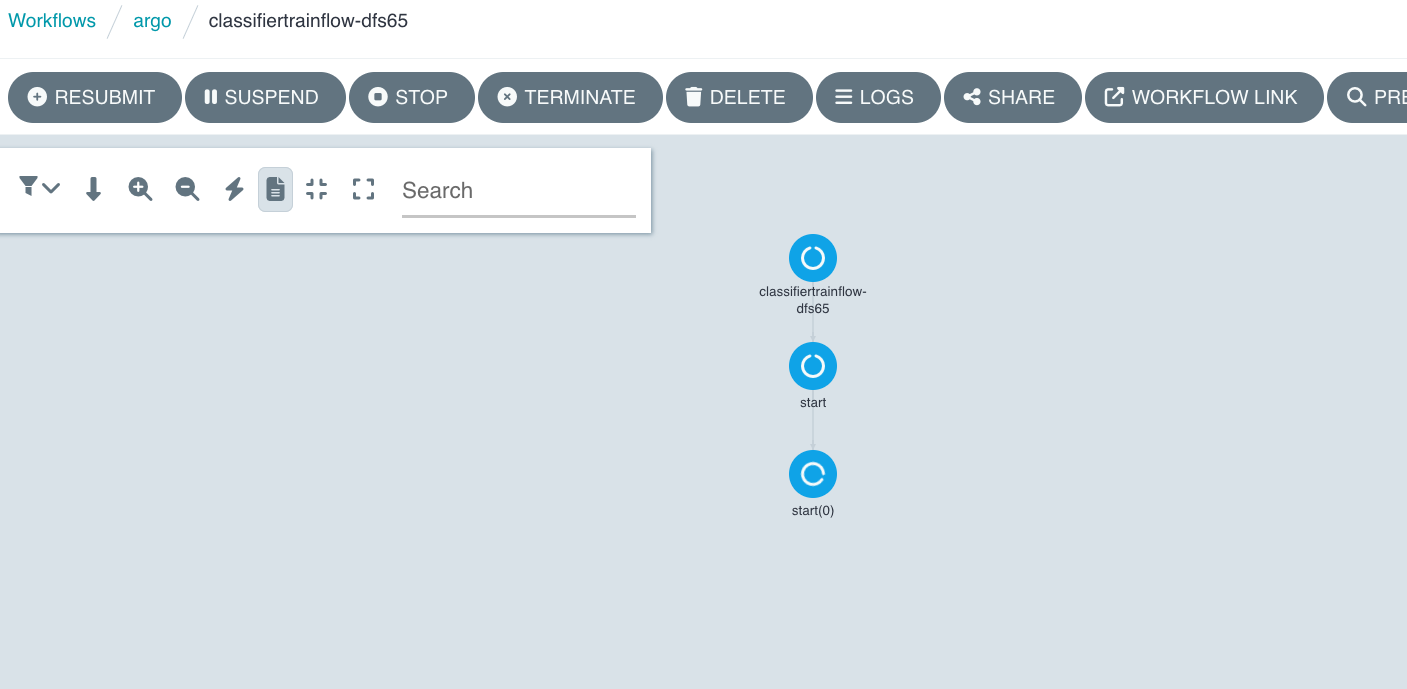

If we run the above `create` command again, it will create a new version of the workflow, and this will become the new production version. If we want to test our flow (stage it) before we put it in production we can simply run it in kubernetes without creating the Argo workflow, or we can change the name of the flow from ClassifierTrainFlow to ClassifierTrainFlowStaging, create an Argo workflow, and make sure it runs.



### Metaflow Cheatsheet

- Flows or workflows: same as a DAG  
- `FlowSpec`: metaflow class for flows  
- `@step`: defines a node in the DAG  
- `start` and `end`: required steps  
- `next(step_name)`: defines edges between nodes  
- artifacts: variables, data, models   
- `self`: use to persist all artifacts  
- parameters: for setting parameter values for runs of the flow  
- branching and merging: for creating more complex DAGs  
- @conda: for dependency management  
- @resources: for specifying size of instances in compute layer  
- @kubernetes (@batch): for running steps in the cloud  
- @timeout, @retry, and @catch: for dealing with errors  
- @schedule: for scheduling flows to run in Argo Workflows (or Airflow)  
- decorators versus --with: rather than hard-code decorators we can include --with (e.g. --with retry or --with kubernetes) to make flows a little more flexible  
- argo_workflows create: to create a workflow to run and schedule in Argo Workflows

# ML Workflows Lab

## Overview

We've learned that a machine learning pipeline, or flow, makes it easy to train and score ML models. But, so far we've only worked on this locally. The real power of ML pipelines is scalability, i.e. in training a model that requires a lot of resources such as data or compute easily, in the cloud, without having to worry about setting up the infrastructure ourselves. ML pipelines can also be useful for model deployment, which we'll cover next time, and model scoring, when we need to worry about making sure our deployed model is always available, and can handle whatever we throw at it. 

## Goal

In this lab we will set up a scalable machine learning training pipeline using Metaflow and GCP and then test our ML training pipeline code from the previous lab.

## Instructions

Use the instructions above to get Metaflow deployed in GCP. You may want to start with a fresh project to test it out, and then you can try running Metaflow and MLFlow in the same GCP project. After you've tested it out, get it running along with your MLFlow Server instance and rerun your training flow from the previous lab using kubernetes on GCP instead of your laptop. 

### Scaling your Training Flow

1. Set up Metaflow to run in GCP on K8s using the instructions above.   
    a. Feel free to test it out on a new clean project before setting it up with your MLFlow-related project.  
2. Create copies of the files you created in Lab 6 and rename them trainingflowgcp.py and scoringflowgcp.py. Add the `@resources` or `@kubernetes` decorators to your flow where they make the most sense (when you need the step to be truly scalable or you can just scale out the entire flow).  
3. Add the `@timeout`, `@retry`, and `@catch` decorators to your flow to avoid errors.  
4. Add the `@conda` or `@conda_base` decorators to control dependencies.  
5. Run your ML training pipeline in GCP. **Take a screenshot** of your terminal that shows that your flow ran successfully in GCP. Be sure that a final model is registered in MLFlow as part of the flow and **take a screenshot** of the newly registered model in the MLFlow dashboard. You **do not** need to use Argo for anything.      
6. To save on costs, once you are all done and have turned in the assignment, I would recommend using `terraform destroy` to destroy the entire infrastructure. You can always get it up and running again using the `terrafrom apply` commands above.

### Turning It In

To show that your model training flow runs successfully in Kubernetes in GCP, take a screenshot of some of the output in the terminal after you `run` your model training flow. Be sure to include the end that shows it was successful and didn't error out.  

Take a screenshot of your new registered model in MLFlow.

Push your new python files that contain your model training flow to Github. In a doc, add the direct link to the `src/` folder in Github, add the two screenshots, and submit as a pdf to Canvas.